In [2]:
import os
import leafmap
from src.grid import *

In [9]:
DATASET_NAME = 'Major-TOM/Core-S2L2A'
grid = Grid(10, latitude_range=(-90,90), longitude_range=(-180,180))
df = pd.read_parquet('https://huggingface.co/datasets/{}/resolve/main/metadata.parquet'.format(DATASET_NAME))

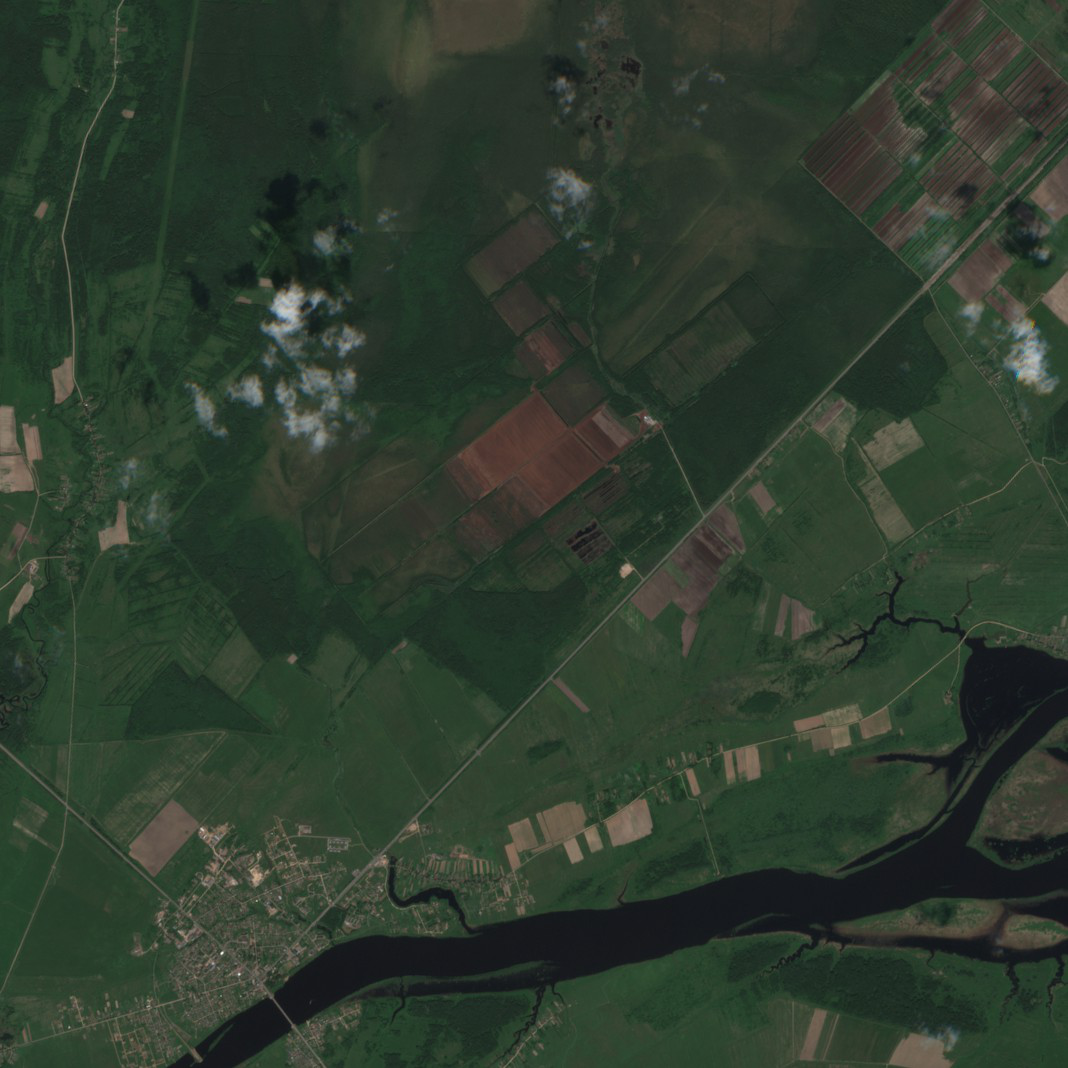

In [4]:
from fsspec.parquet import open_parquet_file
import pyarrow.parquet as pq
from io import BytesIO
from PIL import Image

def gridcell2ints(grid_string):
    up = int(grid_string.split('_')[0][:-1]) * (2*int(grid_string.split('_')[0][-1]=='U') - 1) # +ve if up
    right = int(grid_string.split('_')[1][:-1]) * (2*int(grid_string.split('_')[1][-1]=='R') - 1) # +ve if R

    return up, right

def row2image(parquet_url, parquet_row):
    with open_parquet_file(parquet_url,columns = ["thumbnail"]) as f:
        with pq.ParquetFile(f) as pf:
            first_row_group = pf.read_row_group(parquet_row, columns=['thumbnail'])
    
    stream = BytesIO(first_row_group['thumbnail'][0].as_py())
    return Image.open(stream)

def row2s2(parquet_url, parquet_row, s2_bands = ["B04", "B03", "B02"]):
    with open_parquet_file(parquet_url,columns = s2_bands) as f:
        with pq.ParquetFile(f) as pf:
            first_row_group = pf.read_row_group(parquet_row, columns=s2_bands)
    
    return first_row_group

def cell2row(grid_string, meta_df, return_row = False):
    row_U, col_R = gridcell2ints(grid_string)
    R = meta_df.query('grid_row_u == {} & grid_col_r == {}'.format(row_U, col_R))

    if not R.empty:
        if return_row:
            return R.parquet_url.item(), R.parquet_row.item(), R
        else:
            return R.parquet_url.item(), R.parquet_row.item()
    else:
        return None

def map_to_image(map):

    # 1. get bounds
    bbox = map.get_bbox()
    center = [(bbox[3]+bbox[1])/2, (bbox[2]+bbox[0])/2]

    # 2. translate coordinate to major-tom tile
    rows, cols = grid.latlon2rowcol([center[0]], [center[1]])
    
    # 3. translate major-tom cell to row in parquet
    row = cell2row("{}_{}".format(rows[0],cols[0]), df, return_row = True)

    if row is not None:
        parquet_url, parquet_row, meta_row = row
        img = row2image(parquet_url, parquet_row)
        # 4. acquire image # X. update map
        lat, lon = meta_row.centre_lat.item(), meta_row.centre_lon.item()
        map.set_center(lon, lat, zoom=12)

        return img
    else:
        return None

row2image('https://huggingface.co/datasets/Major-TOM/Core-S2L2A/resolve/main/images/part_03900.parquet', 43)

In [5]:
m = leafmap.Map(
    height=559,
    width=559,
    draw_control=False,
    measure_control=False,
    fullscreen_control=False,
    toolbar_control=False,
    attribution_control=True,
)
m

Map(center=[20, 0], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Zoom…

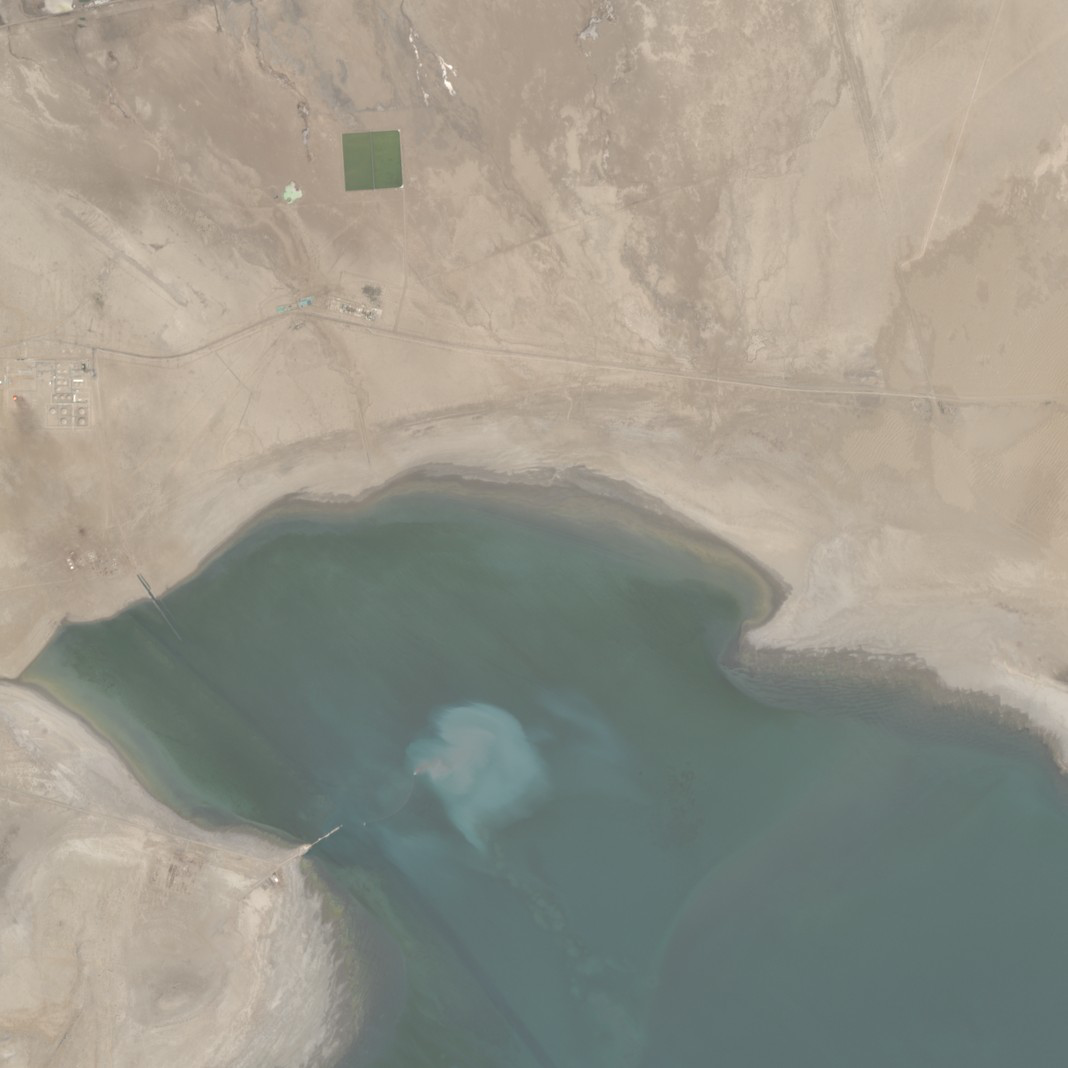

In [10]:
map_to_image(m)